### Cell 1 Explanation
We import basic libraries:
- `pandas` → load dataset
- `numpy` → numerical operations
- `random` → shuffling (for train/test split).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import random
import math
import re
import gdown
np.random.seed(42)

# Cell 2 – Load dataset from Google Drive
Here we download the Mushroom dataset:

- If the file `cleaned_reveiws.csv` is already present, skip downloading.  
- Otherwise, use the `gdown` library to fetch the dataset from Google Drive using its file ID.  
- The dataset is saved locally as `cleaned_reveiws.csv`.


In [ ]:
# Step 2: Load dataset
url = 'https://drive.google.com/file/d/11D4lT4Q22vGkYysO7fuyhPfLvm-glNk-/view?usp=sharing'

# Convert to the “download” link format:
file_id = url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"

output = 'reveiws.csv'
gdown.download(download_url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=11D4lT4Q22vGkYysO7fuyhPfLvm-glNk-
To: /content/reveiws.csv
100%|██████████| 12.9M/12.9M [00:00<00:00, 205MB/s]


'reveiws.csv'

### Cell 3 Explanation
We load the dataset from Google Drive.  
The dataset has:
- `review` (raw review)  
- `cleaned_review` (preprocessed text)  
- `sentiment` (positive/negative).

In [ ]:
# Cell 3 - Load dataset and show basic info
df = pd.read_csv('reveiws.csv')

print(df.head())
print(df.columns)       # should show ['review','cleaned_review','sentiment']
print(df['sentiment'].value_counts())




                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review sentiment  
0  one of the other reviewers has mentioned that ...  positive  
1  a wonderful little production the filming tech...  positive  
2  i thought this was a wonderful way to spend ti...  positive  
3  basically there is a family where a little boy...  negative  
4  petter mattei s love in the time of money is a...  positive  
Index(['review', 'cleaned_review', 'sentiment'], dtype='object')
sentiment
negative    2532
positive    2468
Name: count, dtype: int64


### Cell 4 Explanation
We extract:
- `X` → cleaned reviews (input text)  
- `y` → sentiment labels (target).  
We confirm total samples and unique sentiment classes.


In [ ]:
# Cell 4: Select Features and Labels
X = df["cleaned_review"].values
y = df["sentiment"].values

print("Total samples:", len(X))
print("Unique classes:", set(y))

Total samples: 5000
Unique classes: {'negative', 'positive'}


### Cell 5 Explanation
We shuffle the dataset and split into:
- **70% training data**  
- **30% testing data**  
This ensures random distribution of samples across train/test.


In [ ]:
# Cell 5: Train-Test Split (70/30, Balanced)

data = list(zip(X, y))
random.shuffle(data)

split_index = int(0.7 * len(data))
train_data = data[:split_index]
test_data = data[split_index:]

print("Training size:", len(train_data))
print("Testing size:", len(test_data))


Training size: 3500
Testing size: 1500


### Cell 6 Explanation
We write a simple tokenizer:  
- Convert text to lowercase  
- Split into words (tokens).  
No external library is used.


In [ ]:
# Cell 6: Tokenizer Function (split into words)
def tokenize(text):
    return text.lower().split()


### Cell 7 Explanation
We compute:
- `class_word_counts` → how many times each word appears in each class  
- `class_doc_counts` → how many documents belong to each class  
- `class_priors` → prior probability of each class  
- `vocabulary` → all unique words  
This prepares statistics needed for Naïve Bayes.


In [ ]:
# Cell 7: Training Function (Naïve Bayes)
def train_naive_bayes(train_data, laplace=True):
    class_word_counts = {}
    class_doc_counts = {}
    vocabulary = set()

    # Count words per class
    for text, label in train_data:
        words = tokenize(text)
        vocabulary.update(words)
        class_doc_counts[label] = class_doc_counts.get(label, 0) + 1

        if label not in class_word_counts:
            class_word_counts[label] = {}
        for w in words:
            class_word_counts[label][w] = class_word_counts[label].get(w, 0) + 1

    total_docs = len(train_data)
    class_priors = {c: class_doc_counts[c] / total_docs for c in class_doc_counts}

    return class_word_counts, class_priors, vocabulary, class_doc_counts


### Cell 8 Explanation
Prediction formula:  

\[
P(c|x) \propto P(c) \times \prod_{i=1}^{n} P(w_i|c)
\]

- Uses **log probabilities** to avoid underflow.  
- If `laplace=True`: apply Laplace smoothing.  
- If `laplace=False`: no smoothing (rare words may get zero probability).  
- Final prediction = class with highest score.


In [ ]:
# Cell 8: Prediction Function
def predict(text, class_word_counts, class_priors, vocabulary, class_doc_counts, laplace=True):
    words = tokenize(text)
    scores = {}
    vocab_size = len(vocabulary)

    for c in class_priors:
        log_prob = np.log(class_priors[c])
        total_words_in_class = sum(class_word_counts[c].values())

        for w in words:
            word_count = class_word_counts[c].get(w, 0)
            if laplace:
                prob = (word_count + 1) / (total_words_in_class + vocab_size)
            else:
                if word_count == 0:
                    prob = 1e-9  # avoid log(0)
                else:
                    prob = word_count / total_words_in_class
            log_prob += np.log(prob)

        scores[c] = log_prob
    return max(scores, key=scores.get)


### Cell 9 Explanation
We evaluate the model:
- Loop over test set  
- Predict label for each text  
- Compare with true label  
- Compute **accuracy**, return also `y_true` and `y_pred` (for confusion matrix).


In [ ]:
# Cell 9: Evaluation Function
def evaluate(test_data, model, laplace=True):
    correct = 0
    y_true, y_pred = [], []
    class_word_counts, class_priors, vocabulary, class_doc_counts = model

    for text, label in test_data:
        pred = predict(text, class_word_counts, class_priors, vocabulary, class_doc_counts, laplace)
        y_true.append(label)
        y_pred.append(pred)
        if pred == label:
            correct += 1

    accuracy = correct / len(test_data)
    return accuracy, y_true, y_pred


### Cell 10 Explanation
We train Naïve Bayes **with Laplace smoothing**  
Then evaluate accuracy on the test set.


In [ ]:
# Cell 10: Train and Evaluate (With Laplace Smoothing)
model_laplace = train_naive_bayes(train_data, laplace=True)
acc_laplace, y_true_laplace, y_pred_laplace = evaluate(test_data, model_laplace, laplace=True)

print("Accuracy with Laplace smoothing:", round(acc_laplace,3))


Accuracy with Laplace smoothing: 0.827


# Cell 11: Train and Evaluate (Without Laplace Smoothing)
model_nosmooth = train_naive_bayes(train_data, laplace=False)
acc_nosmooth, y_true_nosmooth, y_pred_nosmooth = evaluate(test_data, model_nosmooth, laplace=False)

print("Accuracy without Laplace smoothing:", acc_nosmooth)


In [ ]:
# Cell 11: Train and Evaluate (Without Laplace Smoothing)
model_nosmooth = train_naive_bayes(train_data, laplace=False)
acc_nosmooth, y_true_nosmooth, y_pred_nosmooth = evaluate(test_data, model_nosmooth, laplace=False)

print("Accuracy without Laplace smoothing:", round(acc_nosmooth,3))


Accuracy without Laplace smoothing: 0.769


### Cell 12 Explanation
We repeat training and testing but **without Laplace smoothing**.  
This allows direct comparison of both methods.


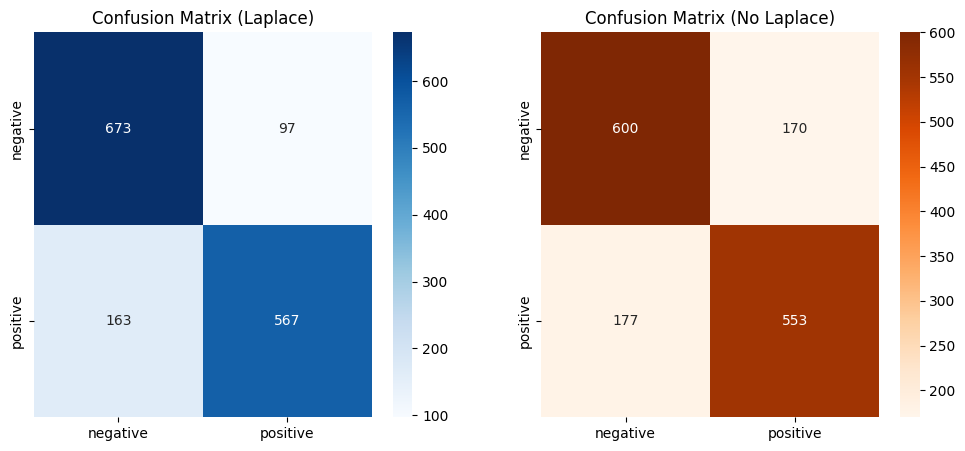

In [ ]:
def my_confusion_matrix(y_true, y_pred, labels):
    matrix = {label: {l:0 for l in labels} for label in labels}
    for t, p in zip(y_true, y_pred):
        matrix[t][p] += 1
    return matrix

# Laplace
cm_laplace = my_confusion_matrix(y_true_laplace, y_pred_laplace, labels)

# No Laplace
cm_no_laplace = my_confusion_matrix(y_true_nosmooth, y_pred_nosmooth, labels)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap([[cm_laplace[a][b] for b in labels] for a in labels], annot=True, fmt="d",
            xticklabels=labels, yticklabels=labels, cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix (Laplace)")

sns.heatmap([[cm_no_laplace[a][b] for b in labels] for a in labels], annot=True, fmt="d",
            xticklabels=labels, yticklabels=labels, cmap="Oranges", ax=axes[1])
axes[1].set_title("Confusion Matrix (No Laplace)")

plt.show()
